# Understanding style transfer

(...)

The following code is largely based on a tutorial of Alexander Mordvintsev on the [Deep Dream technique](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream).

In [1]:
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob

from skimage import io
from sklearn.cluster import KMeans
import sklearn.metrics as sm

import tensorflow as tf

In [2]:
## Load model (a variant of the Inception architecture)

!wget -nc https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip -n inception5h.zip

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

File ‘inception5h.zip’ already there; not retrieving.

Archive:  inception5h.zip


In [3]:
## Retrieve names of the layers
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548



# Find a layer that likes textures

In [ ]:
## Calculate how similar the Gram matrix is for different input images for all layers
## This is used to select the most interesting layers of the network
## There's no need to go through this code

sess = tf.InteractiveSession()
layer_contrast = np.zeros((len(layers),))
for layerX,ii in zip(layers,range(len(layers))):
    
    layerX = layerX+':0'
    
    FileList_anima = glob.glob('clouds/*.jpg')
    image = FileList_anima[0]
    img = io.imread(image, as_grey=True)
    img = np.dstack((img,img,img))
    activations = sess.run(layerX,{t_input: img})
    
    Z = np.zeros((activations.shape[3],activations.shape[3],40))

    FileList_anima = glob.glob('clouds/*.jpg')
    for idx in range(20):
        image = FileList_anima[idx]
        img = io.imread(image, as_grey=True)
        img = np.dstack((img,img,img))

        activations = sess.run(layerX,{t_input: img})
    
        for jj in range(activations.shape[3]):
            A = np.squeeze(activations[0,:,:,jj])
            for kk in range(activations.shape[3]):
                B = np.squeeze(activations[0,:,:,kk])
                Z[jj,kk,idx] = np.corrcoef(A.flatten(),B.flatten())[0,1]
                
    FileList_anima = glob.glob('cracked_concrete/*.jpg')    
    for idx in range(20):
        image = FileList_anima[idx]
        img = io.imread(image, as_grey=True)
        img = np.dstack((img,img,img))

        activations = sess.run(layerX,{t_input: img})
    
        for jj in range(activations.shape[3]):
            A = np.squeeze(activations[0,:,:,jj])
            for kk in range(activations.shape[3]):
                B = np.squeeze(activations[0,:,:,kk])
                Z[jj,kk,idx+20] = np.corrcoef(A.flatten(),B.flatten())[0,1]
        
    ZX = np.zeros((40,40))
    for jj in range(40):
        for kk in range(40):
            ZX[jj,kk] = np.corrcoef(Z[:,:,jj].flatten(),Z[:,:,kk].flatten())[0,1]
    values_on = (np.mean(ZX[0:20,0:20].flatten())+np.mean(ZX[20:40,20:40].flatten()) )/2
    values_off = (np.mean(ZX[20:40,0:20].flatten())+np.mean(ZX[0:20,20:40].flatten()) )/2
    layer_contrast[ii] = (values_on - values_off)/(values_on + values_off)


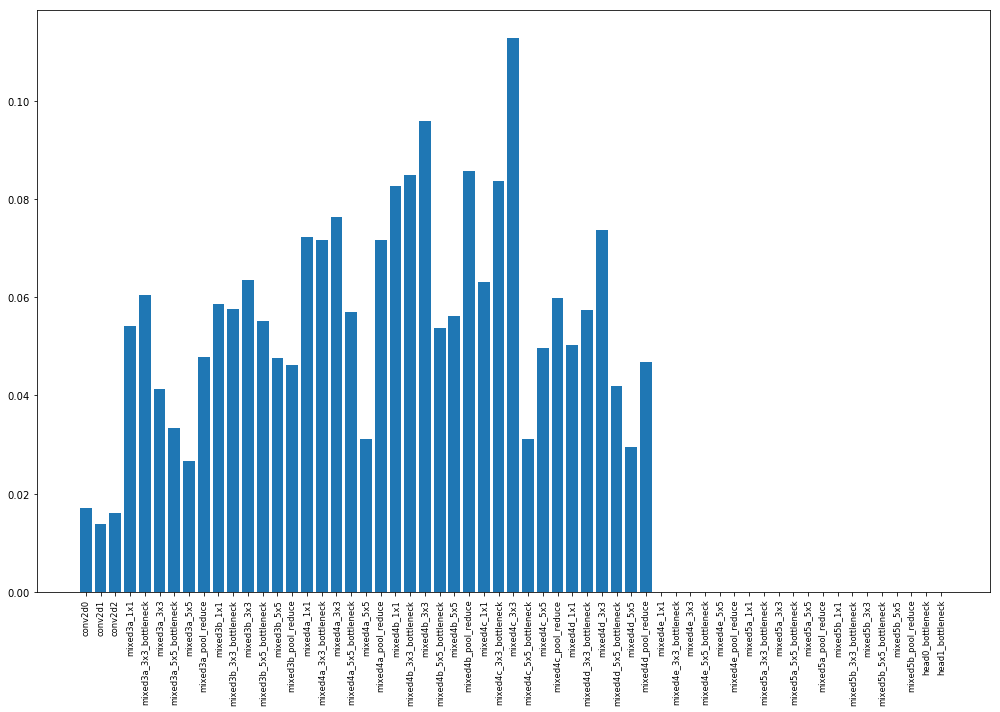

In [28]:
layers_short = np.copy(layers)
for kk in range(len(layers)):
    layers_short[kk] = layers[kk][7:-14]
    
plt.figure(18)
plt.bar(range(len(layers)), layer_contrast, align='center')
plt.xticks(range(len(layer_contrast)), layers_short, size='small', rotation='vertical')
plt.tight_layout()
plt.show()

# Compute Gram matrices for layer 29

In [9]:
## Compute the Gram matrices for layer 29 of the network for a bunch of
## 1) cloud textures and 2) cracked concrete textures
    
layerX = layers[29]
layerX = layerX+':0'

FileList_anima = glob.glob('clouds/*.jpg')
image = FileList_anima[0]
img = mpimg.imread(image)
activations = sess.run(layerX,{t_input: img})

Z = np.zeros((activations.shape[3],activations.shape[3],40))

FileList_anima = glob.glob('clouds/*.jpg')
for idx in range(20):
    print(idx)
    image = FileList_anima[idx]
    img = mpimg.imread(image)

    activations = sess.run(layerX,{t_input: img})

    for jj in range(activations.shape[3]):
        A = np.squeeze(activations[0,:,:,jj])
        for kk in range(activations.shape[3]):
            B = np.squeeze(activations[0,:,:,kk])
            Z[jj,kk,idx] = np.corrcoef(A.flatten(),B.flatten())[0,1]
            
FileList_anima = glob.glob('cracked_concrete/*.jpg')    
for idx in range(20):
    print(idx+20)
    image = FileList_anima[idx]
    img = mpimg.imread(image)

    activations = sess.run(layerX,{t_input: img})

    for jj in range(activations.shape[3]):
        A = np.squeeze(activations[0,:,:,jj])
        for kk in range(activations.shape[3]):
            B = np.squeeze(activations[0,:,:,kk])
            Z[jj,kk,idx+20] = np.corrcoef(A.flatten(),B.flatten())[0,1]
    
ZX = np.zeros((40,40))
for jj in range(40):
    for kk in range(40):
        ZX[jj,kk] = np.corrcoef(Z[:,:,jj].flatten(),Z[:,:,kk].flatten())[0,1]


# Define the deep dream algorithm

In [11]:
## Define the deep dream algorithm; most of this is basically copy-and-paste from A. Mordvintsev's code

img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)


k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]


def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4,figindex=102):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
    if figindex > 0:
        plt.figure(figindex)
    plt.imshow(visstd(img))

# Examples of input images and feature maps

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

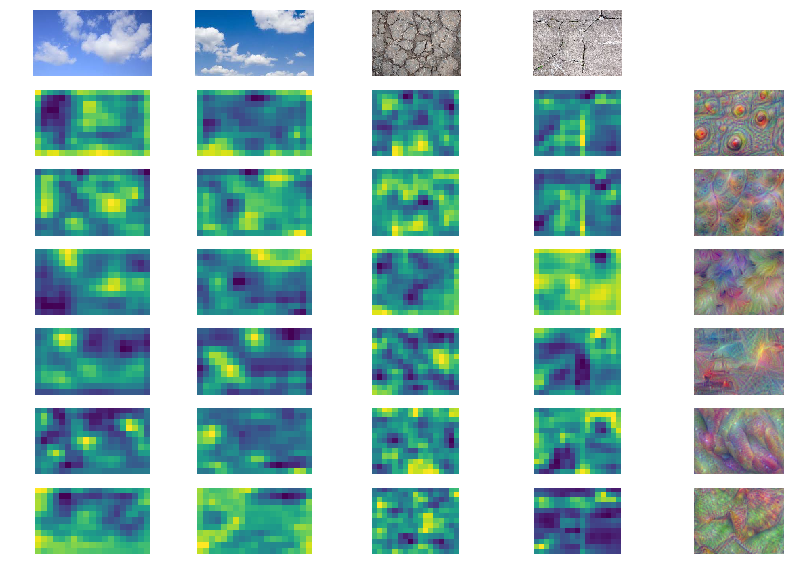

In [17]:
# plot a couple of input images and the resulting feature maps (=activation patterns)
%matplotlib inline
plt.rcParams["figure.figsize"] = (14,10)
plt.figure(4)
for kk in range(4):
    if kk < 2:
        FileList_anima = glob.glob('clouds/*.jpg')
        index = kk
        index2 = kk
    else:
        FileList_anima = glob.glob('cracked_concrete/*.jpg')
        if kk == 2:
            index = 12
            index2 = 20
        else:
            index = 17
            index2 = 29

    image = FileList_anima[index]
    img = mpimg.imread(image)
    activations = sess.run(layerX,{t_input: img})
    
    feature_map_indizes = np.array([3, 4, 14,15, 18, 33])
    
    ax = plt.subplot(7,5, kk+1)
    plt.imshow(img,cmap=plt.get_cmap('Greys'))# , vmin=-0.8, vmax=0.8)
    plt.axis('off') 
    for jj in range(6):
        ax = plt.subplot(7,5, kk+1 + 5*(jj+1))
        
        plt.imshow(np.squeeze(activations[:,:,:,feature_map_indizes[jj] ] ) )
        plt.axis('off') 
        if kk == 0:
            plt.subplot(7,5, 5 + 5*(jj+1))
            layer = 'mixed4c_3x3_pre_relu/conv'
            render_lapnorm(T(layer)[:,:,:,feature_map_indizes[jj]],figindex=0,img0=np.random.uniform(size=(50,68,3)) + 100.0)
            plt.axis('off') 

# k-means clustering of Gram matrices

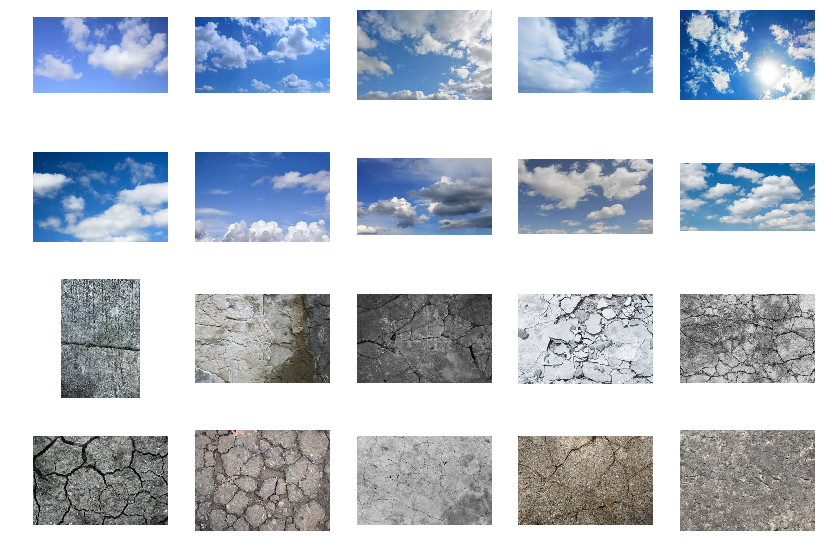

In [23]:
## Show example input images

plt.figure(5)
for kk in range(20):
    ax = plt.subplot(4, 5, kk+1)
    if kk < 10:
        FileList_anima = glob.glob('clouds/*.jpg')
        image = FileList_anima[kk*2]
        img = mpimg.imread(image)
    else:
        FileList_anima = glob.glob('cracked_concrete/*.jpg')
        image = FileList_anima[(kk-10)*2]
        img = mpimg.imread(image)
    plt.imshow(img,cmap=plt.get_cmap('Greys'))
    plt.axis('off') 

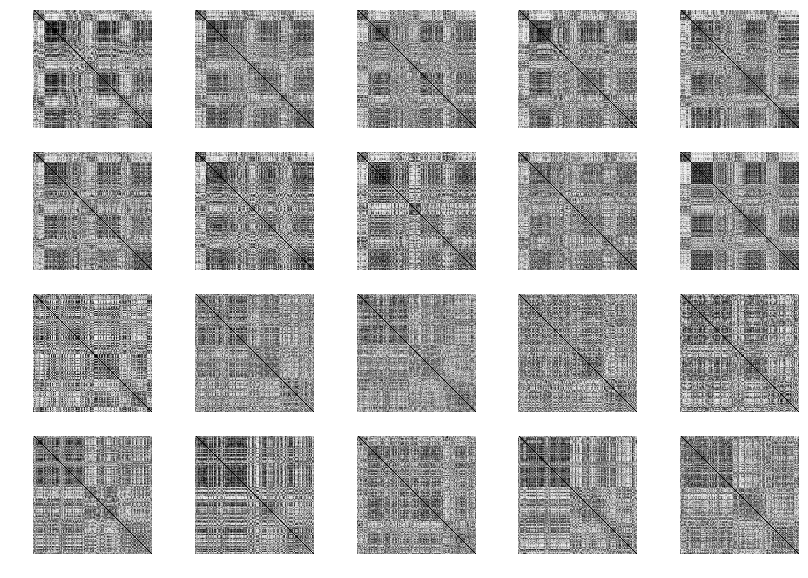

In [22]:
Z_mean = np.mean(Z,axis=2)

model = KMeans(n_clusters=7)
model.fit(Z_mean)
indizes = model.labels_
order_indizes = np.argsort(indizes)

plt.figure(4)
for kk in range(20):
    ax = plt.subplot(4, 5, kk+1)
    Z2 = np.zeros(Z_mean.shape)
    ZXY = np.copy(Z_mean)
    for jj in range(Z_mean.shape[0]):
        for ii in range(Z_mean.shape[1]):
            ZXY[jj,ii] = Z[order_indizes[jj],order_indizes[ii],kk*2]
    plt.imshow(ZXY,cmap=plt.get_cmap('Greys'), vmin=-0.8, vmax=0.8)
    plt.axis('off')    

# Deep dreams based on feature maps 

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

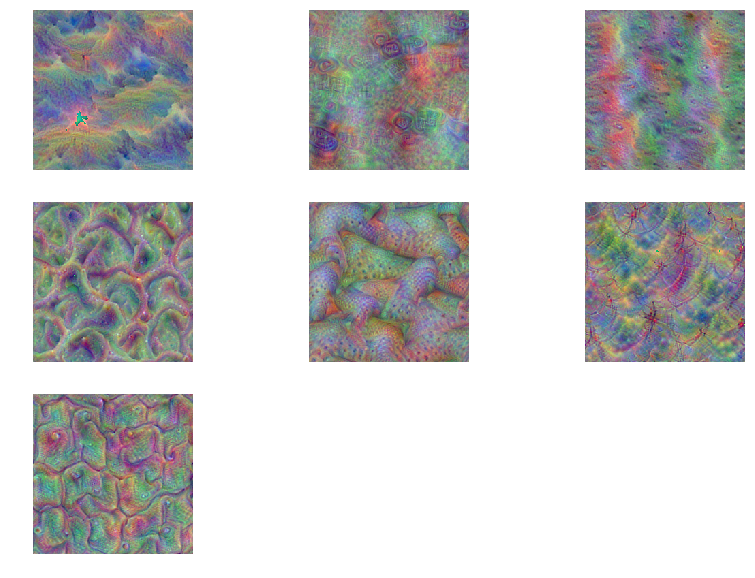

In [26]:
## Deep dreams based on feature maps 

TX1 = T(layer)[:,:,:,order_indizes[0]]- T(layer)[:,:,:,order_indizes[0]]
TX2 = T(layer)[:,:,:,order_indizes[0]]- T(layer)[:,:,:,order_indizes[0]]
TX3 = T(layer)[:,:,:,order_indizes[0]]- T(layer)[:,:,:,order_indizes[0]]
TX4 = T(layer)[:,:,:,order_indizes[0]]- T(layer)[:,:,:,order_indizes[0]]
TX5 = T(layer)[:,:,:,order_indizes[0]]- T(layer)[:,:,:,order_indizes[0]]
TX6 = T(layer)[:,:,:,order_indizes[0]]- T(layer)[:,:,:,order_indizes[0]]
TX7 = T(layer)[:,:,:,order_indizes[0]]- T(layer)[:,:,:,order_indizes[0]]
for kk in range(len(order_indizes)):
    if indizes[kk] == 0:
        TX1 = TX1 + T(layer)[:,:,:,kk]
    elif indizes[kk] == 1:
        TX2 = TX2 + T(layer)[:,:,:,kk]               
    elif indizes[kk] == 2:
        TX3 = TX3 + T(layer)[:,:,:,kk]               
    elif indizes[kk] == 3:
        TX4 = TX4 + T(layer)[:,:,:,kk]               
    elif indizes[kk] == 4:
        TX5 = TX5 + T(layer)[:,:,:,kk]               
    elif indizes[kk] == 5:
        TX6 = TX6 + T(layer)[:,:,:,kk]               
    elif indizes[kk] == 6:
        TX7 = TX7 + T(layer)[:,:,:,kk]
        

img1 = np.random.uniform(size=(120,120,3)) + 100.0    
plt.figure(332)
for kk in range(7):
    ax = plt.subplot(3, 3, kk+1)
    if kk == 0:
        render_lapnorm(TX1,figindex=0,img0=img1)
    elif kk == 1:
        render_lapnorm(TX2,figindex=0,img0=img1)
    elif kk == 2:
        render_lapnorm(TX3,figindex=0,img0=img1)
    elif kk == 3:
        render_lapnorm(TX4,figindex=0,img0=img1)
    elif kk == 4:
        render_lapnorm(TX5,figindex=0,img0=img1)
    elif kk == 5:
        render_lapnorm(TX6,figindex=0,img0=img1)
    elif kk == 6:
        render_lapnorm(TX7,figindex=0,img0=img1)
    plt.axis('off')